In [1]:
import yfinance as yf
import pandas   as pd
import numpy    as np


In [2]:
btc = yf.Ticker("BTC-USD").history(period="30y")

btc_levels = btc['Close'].copy()
btc_levels

Date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2022-07-24    22609.164062
2022-07-25    21361.701172
2022-07-26    21239.753906
2022-07-27    22930.548828
2022-07-28    23923.765625
Name: Close, Length: 2872, dtype: float64

In [3]:
def sma(data_levels,params = 50):
    
    data = pd.DataFrame(data_levels).copy()
    
    data['SMA_{}'.format(params)]  = data.iloc[:,0].rolling(params).mean()
    data['Returns'] = data.iloc[:,0].pct_change()
    data = data.dropna()

    signals = []

    for i in range(len(data)):
        
        ## if SMA > current price = buy
        if data.iloc[:,0].iloc[i] > data.iloc[:,1].iloc[i]:
            signals.append(1)
        
        # if SMA < current price = sell
        if data.iloc[:,0].iloc[i] < data.iloc[:,1].iloc[i]:
            signals.append(0)
            
        # if SMA == current price = do nothing (this wont happen)
        if data.iloc[:,0].iloc[i] == data.iloc[:,1].iloc[i]:
            print('test')
            signals.append(0)
            
    data['Signals'] = signals
    
    return data

,Close,SMA_50,Returns,Signals
Date,,,,
2014-11-05,339.485992,372.766840,0.027214,0
2014-11-06,349.290009,370.605960,0.028879,0
2014-11-07,342.415009,368.965460,-0.019683,0
2014-11-08,345.488007,367.979301,0.008974,0
2014-11-09,363.264008,367.066501,0.051452,0
...,...,...,...,...
2022-07-24,22609.164062,22384.998672,0.006396,1
2022-07-25,21361.701172,22214.099453,-0.055175,0
2022-07-26,21239.753906,22011.481094,-0.005709,0


<AxesSubplot:xlabel='Date'>

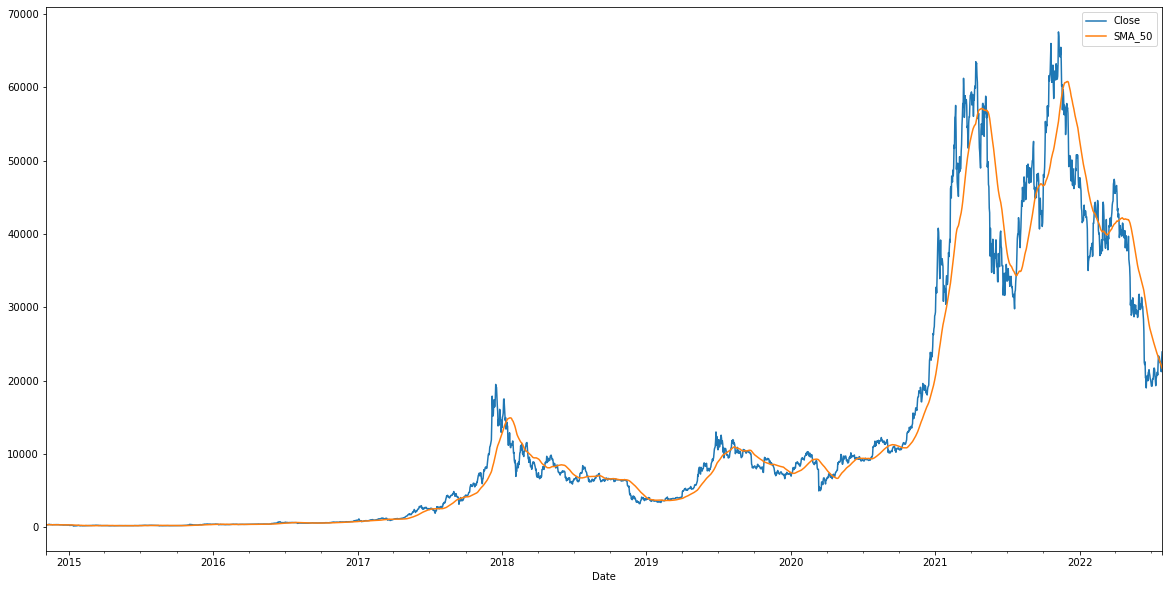

In [4]:
df = sma(btc_levels)

display(df)

df[['Close','SMA_50']].plot(figsize = (20,10))

In [5]:
def backtester(signals,price, tcost = 0.005):

        pos_val = np.zeros(np.shape(price))
        cash    = np.zeros(np.shape(price))
        cash[0] = 1

        for i,val in enumerate(price):

            if i == len(price)-1:
                break


            if signals[i] == 0:

                cash[i+1] = (pos_val[i] * val * (1-tcost)) + cash[i]
                pos_val[i+1] = 0

            elif signals[i] == 1:

                pos_val[i+1] = (cash[i] / val)*((1-tcost)) + pos_val[i]
                cash[i+1] = 0


        returns = [a*b for a,b in zip(pos_val,price)] + cash
        
        return pd.DataFrame(returns, index = price.index)

In [6]:
returns = backtester(df['Signals'],df['Close'])



<AxesSubplot:xlabel='Date'>

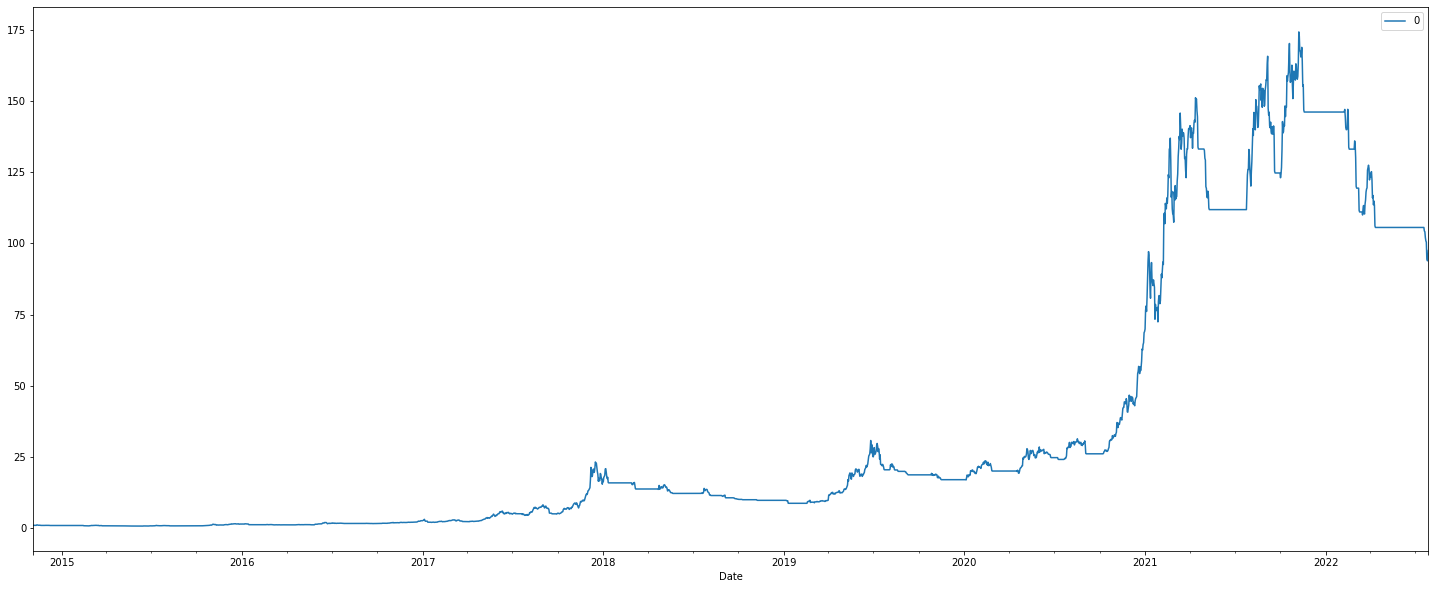

In [7]:
returns.plot(figsize = (25,10))

In [8]:
tps = []

sigs = df['Signals'][1:-1].values.ravel()

rets = (returns.pct_change()).shift(1).dropna().values.ravel()

for i,val in enumerate(sigs):
    
    if (sigs[i] == 1 and rets[i]>0):
        tps.append(1)
        
win_rate = sum(tps)/len(sigs)
win_rate

0.3172633817795108